 https://github.com/SGeorgilas/Machine-Learning-Rock-Scissors-Paper-Agent

##Importing Libraries

In [ ]:
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!pip install Pillow

##Initialization of folder paths

In [ ]:
# Οι φακέλοι στο Google Colab
rock_folder = '/content/Rock'
scissors_folder = '/content/Scissors'
paper_folder = '/content/Paper'

# Δημιουργία λεξικού για την αντιστοίχιση κίνησης σε τιμή
move_mapping = {'Rock': 0, 'Scissors': 1, 'Paper': 2}

##Preparing images and assigning labels


In [ ]:
# Συνάρτηση για τη φόρτωση, μείωση διαστατικότητας και κανονικοποίηση μιας εικόνας
def load_and_preprocess_image(image_path, move_mapping):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Μετατροπή σε ασπρόμαυρη εικόνα
    img = cv2.resize(img, (100, 100)) / 255.0  # Κανονικοποίηση στο [0, 1] και αλλαγή μεγέθους
    move = os.path.basename(os.path.dirname(image_path))
    move_value = move_mapping.get(move, None)
    return img, move_value

# Συλλογή εικόνων και αντίστοιχων τιμών
all_images = []
all_labels = []

for img_path in os.listdir(rock_folder):
    img_path = os.path.join(rock_folder, img_path)
    img_array, move_value = load_and_preprocess_image(img_path, move_mapping)
    all_images.append(img_array)
    all_labels.append(move_value)

for img_path in os.listdir(scissors_folder):
    img_path = os.path.join(scissors_folder, img_path)
    img_array, move_value = load_and_preprocess_image(img_path, move_mapping)
    all_images.append(img_array)
    all_labels.append(move_value)

for img_path in os.listdir(paper_folder):
    img_path = os.path.join(paper_folder, img_path)
    img_array, move_value = load_and_preprocess_image(img_path, move_mapping)
    all_images.append(img_array)
    all_labels.append(move_value)

# Μετατροπή σε numpy array
all_images = np.array(all_images)
all_labels = np.array(all_labels)

##Implementing the Random Agent

In [ ]:
class RandomAgent:
    def __init__(self, data_folder, model_folder):
        self.moves = {'Rock': 0, 'Scissors': 1, 'Paper': 2}
        self.data_folder = data_folder
        self.image_size = (100, 100)
        self.model_folder = model_folder
        self.model = self.build_and_train_model()

    def load_and_preprocess_image(self, image_path):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.image_size) / 255.0
        return img

    def build_and_train_model(self):
        # Συναρτήσεις για φόρτωση και προεπεξεργασία των εικόνων
        def load_images_and_labels(folder, test_size=0.2, random_state=0):
            images = []
            labels = []
            for label, move in enumerate(['Rock', 'Scissors', 'Paper']):
                move_folder = os.path.join(folder, move)

                # Load images for the current move
                move_images = []
                for filename in os.listdir(move_folder):
                    image_path = os.path.join(move_folder, filename)
                    img, _ = load_and_preprocess_image(image_path, self.moves)
                    move_images.append(img)

                # Append the images and labels
                images.extend(move_images)
                labels.extend([label] * len(move_images))

            # Split the combined images into train and test sets
            train_images, test_images, train_labels, test_labels = train_test_split(images, labels,
                                                                                    test_size=test_size,
                                                                                    random_state=random_state)

            return np.array(train_images), np.array(test_images), np.array(train_labels), np.array(test_labels)

        # Φόρτωση των εικόνων και των ετικετών
        train_images, test_images, train_labels, test_labels = load_images_and_labels(self.data_folder)


        # Κατασκευή του CNN μοντέλου
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(3, activation='softmax'))  # 3 κλάσεις (Rock, Scissors, Paper)


        optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
        # Σύνολο των υπερπαραμέτρων και αλγορίθμου εκπαίδευσης
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Εκπαίδευση του μοντέλου
        model.fit(train_images.reshape(-1, 100, 100, 1), train_labels, epochs=10, validation_data=(test_images.reshape(-1, 100, 100, 1), test_labels))

        # Αποθήκευση του μοντέλου στον φάκελο
        model.save(self.model_folder)
        return model, train_images, test_images, train_labels, test_labels

    def choose_random_image(self, p1, p2, noise_std=0.05, test_set_images=None, test_labels=None):
    # If test_set_images is provided, randomly choose an image from it
        if test_set_images is not None and len(test_set_images) > 0:
            random_index = np.random.choice(len(test_set_images))
            random_image = test_set_images[random_index]
            move_label = test_labels[random_index]
            move_name = next(key for key, value in self.moves.items() if value == move_label)
        else:
        # If test_set_images is not provided, choose a random move and image from the corresponding folder
            random_move = np.random.choice(list(self.moves.values()))
            move_name = next(key for key, value in self.moves.items() if value == random_move)

            move_folder = os.path.join(self.data_folder, move_name)
            random_image_path = os.path.join(move_folder, np.random.choice(os.listdir(move_folder)))

        # Load and preprocess the image
            random_image = self.load_and_preprocess_image(random_image_path)
            random_image = self.augment_image(random_image, p1, p2, noise_std)

        return random_image, move_name

    def augment_image(self, img, p1, p2, noise_std):
        # Εφαρμογή Vertical Flip με πιθανότητα p1
        if np.random.rand() < p1:
            img = np.flipud(img)

        # Εφαρμογή Horizontal Flip με πιθανότητα p2
        if np.random.rand() < p2:
            img = np.fliplr(img)

        # Προσθήκη θορύβου
        noise = np.random.normal(0, noise_std, img.shape)
        img_with_noise = img + noise

        # Κανονικοποίηση της εικόνας
        img_with_noise = np.clip(img_with_noise, 0, 1)

        return img_with_noise

##Implementing my agent

In [ ]:
class YourAgent:
    def __init__(self, model_folder):
        self.model = tf.keras.models.load_model(model_folder)
        self.moves = {0: 'Rock', 1: 'Scissors', 2: 'Paper'}

    def read_image(self, image):
        # Εφαρμογή του μοντέλου για αναγνώριση της εικόνας
        prediction = self.model.predict(image.reshape(1, 100, 100, 1))[0]
        predicted_move = np.argmax(prediction)
        return self.moves[predicted_move]


##Initializing the agents

In [ ]:
# Φάκελος με τις εικόνες
data_folder = '/content'
# Φάκελος για το μοντέλο
model_folder = '/content/model'

# Δημιουργία του πράκτορα Random Agent
random_agent = RandomAgent(data_folder, model_folder)

# Δημιουργία του πράκτορα σας
your_agent = YourAgent(model_folder)

Epoch 1/10
55/55 [==============================] - 34s 587ms/step - loss: 1.0170 - accuracy: 0.4600 - val_loss: 0.6531 - val_accuracy: 0.7215
Epoch 2/10
55/55 [==============================] - 29s 526ms/step - loss: 0.4829 - accuracy: 0.8194 - val_loss: 0.3826 - val_accuracy: 0.8493
Epoch 3/10
55/55 [==============================] - 29s 535ms/step - loss: 0.3924 - accuracy: 0.8423 - val_loss: 0.2856 - val_accuracy: 0.8904
Epoch 4/10
55/55 [==============================] - 29s 526ms/step - loss: 0.3238 - accuracy: 0.8794 - val_loss: 0.2387 - val_accuracy: 0.9132
Epoch 5/10
55/55 [==============================] - 29s 525ms/step - loss: 0.2668 - accuracy: 0.9029 - val_loss: 0.2139 - val_accuracy: 0.9247
Epoch 6/10
55/55 [==============================] - 29s 535ms/step - loss: 0.2445 - accuracy: 0.9177 - val_loss: 0.2188 - val_accuracy: 0.9178
Epoch 7/10
55/55 [==============================] - 32s 576ms/step - loss: 0.2061 - accuracy: 0.9211 - val_loss: 0.1957 - val_accuracy: 0.9315

##Choosing best move

In [ ]:
# Η συνάρτηση που θα καλείται από τον Random Agent για να επιλέξει τη βέλτιστη ενέργεια
def select_best_action(image):
    # Διάβασμα της εικόνας από τον πράκτορα σας
    predicted_move = your_agent.read_image(image)
    if predicted_move == 'Paper':
       move = 'Scissors'
    if predicted_move == 'Rock':
       move = 'Paper'
    if predicted_move == 'Scissors':
       move = 'Rock'
    return move,predicted_move

In [ ]:
p1 = 0.5
p2 = 0.5
noise_std = 0.05
budget = 0
budget_history = []

# Build and train the model, and get the train/test datasets
model, train_images, test_images, train_labels, test_labels = random_agent.build_and_train_model()

for round_num in range(1, 201):
    print(f"\nRound {round_num}")
    random_image, actual_move = random_agent.choose_random_image(p1, p2, noise_std, test_set_images=test_images,test_labels=test_labels)
    # Επιλογή βέλτιστης ενέργειας από τον πράκτορα σας
    best_action, predicted_action = select_best_action(random_image)
    print("Προβλέπω πως είναι " + predicted_action + " και παίζω " + best_action)
    print("Τελικά η κίνηση ήταν " + str(actual_move))
    Image.fromarray((random_image * 255).astype(np.uint8))
    if str(actual_move) == 'Rock':
        if best_action == 'Rock':
            print("It's a draw!")
        elif best_action == 'Paper':
            print("Your Agent wins!")
            budget = budget + 1
        else:
            print("Random Agent wins!")
            budget = budget - 1
    elif str(actual_move) == 'Paper':
        if best_action == 'Rock':
            print("Random Agent wins!")
            budget = budget - 1
        elif best_action == 'Paper':
            print("It's a draw!")
        else:
            print("Your Agent wins!")
            budget = budget + 1
    elif str(actual_move) == 'Scissors':
        if best_action == 'Rock':
            print("Your Agent wins!")
            budget = budget + 1
        elif best_action == 'Paper':
            print("Random Agent wins!")
            budget = budget - 1
        else:
            print("It's a draw!")
    budget_history.append(budget)

Epoch 1/10
55/55 [==============================] - 31s 545ms/step - loss: 0.9798 - accuracy: 0.5166 - val_loss: 0.5707 - val_accuracy: 0.7763
Epoch 2/10
55/55 [==============================] - 31s 567ms/step - loss: 0.4277 - accuracy: 0.8411 - val_loss: 0.2697 - val_accuracy: 0.9064
Epoch 3/10
55/55 [==============================] - 29s 523ms/step - loss: 0.2418 - accuracy: 0.9126 - val_loss: 0.3680 - val_accuracy: 0.8699
Epoch 4/10
55/55 [==============================] - 28s 509ms/step - loss: 0.2049 - accuracy: 0.9280 - val_loss: 0.1632 - val_accuracy: 0.9452
Epoch 5/10
55/55 [==============================] - 29s 530ms/step - loss: 0.1096 - accuracy: 0.9680 - val_loss: 0.1266 - val_accuracy: 0.9589
Epoch 6/10
55/55 [==============================] - 30s 555ms/step - loss: 0.0838 - accuracy: 0.9726 - val_loss: 0.1242 - val_accuracy: 0.9566
Epoch 7/10
55/55 [==============================] - 29s 523ms/step - loss: 0.0806 - accuracy: 0.9749 - val_loss: 0.2104 - val_accuracy: 0.9361

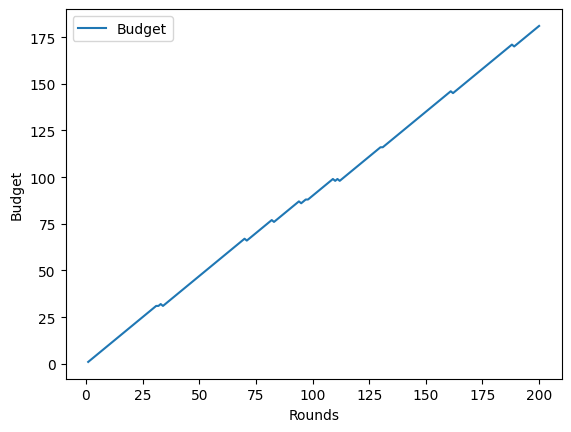

In [ ]:
plt.plot(range(1, 201), budget_history, label="Budget")
plt.xlabel("Rounds")
plt.ylabel("Budget")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/model')

# Load and preprocess the image
image_path = '/content/hand.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (100, 100)) / 255.0
input_data = np.expand_dims(img, axis=(0, 3))

# Make a prediction
predictions = model.predict(input_data)
predicted_class = np.argmax(predictions)

# Map the predicted class to the corresponding move
moves_mapping = {0: 'Rock', 1: 'Scissors', 2: 'Paper'}
predicted_move = moves_mapping[predicted_class]

# Display the result
print(f"The predicted move for the given image is: {predicted_move}")

1/1 [==============================] - 0s 89ms/step
The predicted move for the given image is: Scissors
